<a href="https://colab.research.google.com/github/RonaldGarcia02/Predicting-Flight-Delays/blob/main/Predicting_Flight_Delays.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Flight Delay Predictor, using Real-Time data

# Collecting Real Time Data / Do Not Run

Using API to Scrape real time Data

*   It is setup to collect real time data
*   Will not get used for the resy of the project due to the time needed to collect enough data



I import:
- `requests` to send API requests and fetch real-time flight data
- `pandas` to structure and manipulate that data in table (DataFrame) format

In [3]:
import requests
import pandas as pd
import time

I store my API key (from AviationStack) as a string in a variable called `api_key`. This key authenticates us when we request data from the API.

In [ ]:
api_key = 'd91f4681c58385353898d3d75c8c2100'

I loop through each flight in the API data. For each flight, I:
- Extract fields like airline name, airports, scheduled/actual times, and status
- Store them in a dictionary (`row`)
- Append that dictionary to `flights_list`

If a flight is missing a field, I skip it and print a warning.

In [ ]:
url = f'http://api.aviationstack.com/v1/flights?access_key={api_key}&limit=100'
response = requests.get(url)
data = response.json()

flights_list = []
for flight in data['data']:
    try:
        row = {
            'airline_name': flight['airline']['name'],
            'flight_number': flight['flight']['iata'],
            'departure_airport': flight['departure']['airport'],
            'arrival_airport': flight['arrival']['airport'],
            'scheduled_departure': flight['departure']['scheduled'],
            'actual_departure': flight['departure']['actual'],
            'scheduled_arrival': flight['arrival']['scheduled'],
            'actual_arrival': flight['arrival']['actual'],
            'flight_status': flight['flight_status']
        }
        flights_list.append(row)
    except:
      continue

I convert the `flights_list` into pandas DataFrame called `df`

In [ ]:
df = pd.DataFrame(flights_list)

In [ ]:
df = df.dropna(subset=['scheduled_departure', 'actual_departure'])

In [ ]:
df['scheduled_departure'] = pd.to_datetime(df['scheduled_departure'])
df['actual_departure'] = pd.to_datetime(df['actual_departure'])
df['departure_delay_minutes'] = (df['actual_departure'] - df['scheduled_departure']).dt.total_seconds() / 60
df['delayed'] = df['departure_delay_minutes'] > 15

In [ ]:
df.head()

In [ ]:
df.to_csv('flight_data.csv', mode='a', index=False, header=False)
print(f"Appended {len(df)} rows to CSV")

Appended 3 rows to CSV


# Using Bureau of Transportation Historical Data

In [6]:
import pandas as pd

In [7]:
df = pd.read_csv('flightsjan2025.csv')

In [8]:
df.columns

Index(['FL_DATE', 'OP_UNIQUE_CARRIER', 'OP_CARRIER_FL_NUM', 'ORIGIN', 'DEST',
       'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY_NEW', 'DEP_DEL15',
       'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY_NEW'],
      dtype='object')

In [9]:
columns_to_keep = ['FL_DATE', 'OP_UNIQUE_CARRIER', 'OP_CARRIER_FL_NUM','ORIGIN', 'DEST','CRS_DEP_TIME','DEP_DELAY_NEW', 'DEP_DEL15']

In [10]:
df = df[columns_to_keep]

In [11]:
df = df.rename(columns={
    'FL_DATE': 'flight_date',
    'OP_UNIQUE_CARRIER': 'airline',
    'OP_CARRIER_FL_NUM': 'flight_number',
    'ORIGIN': 'origin',
    'DEST': 'destination',
    'CRS_DEP_TIME': 'crs_dep_time',
    'DEP_TIME': 'actual_dep_time',
    'DEP_DELAY_NEW': 'departure_delay_minutes',
    'DEP_DEL15': 'is_delayed'
})

In [12]:
df.head()

,flight_date,airline,flight_number,origin,destination,crs_dep_time,departure_delay_minutes,is_delayed
0,1/1/2025 12:00:00 AM,AA,1,JFK,LAX,659,0.0,0.0
1,1/1/2025 12:00:00 AM,AA,10,LAX,JFK,2200,0.0,0.0
2,1/1/2025 12:00:00 AM,AA,1002,MSN,CLT,644,36.0,1.0
3,1/1/2025 12:00:00 AM,AA,1004,PHL,LAS,1855,1.0,0.0
4,1/1/2025 12:00:00 AM,AA,1005,ORD,PHX,830,0.0,0.0


In [13]:
df = df.dropna(subset=['crs_dep_time', 'departure_delay_minutes', 'is_delayed'])

In [14]:
df['flight_date'] = pd.to_datetime(df['flight_date'])

<ipython-input-14-59ecd9cad000>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['flight_date'] = pd.to_datetime(df['flight_date'])


In [15]:
df['crs_dep_time'] = df['crs_dep_time'].astype(str).str.zfill(4)

In [16]:
df['dep_hour'] = df['crs_dep_time'].str[:2].astype(int)

In [17]:
df['day_of_week'] = df['flight_date'].dt.dayofweek

In [18]:
df['is_delayed'] = df['is_delayed'] == 1

In [19]:
df = df[['flight_date', 'airline', 'origin', 'destination', 'dep_hour', 'day_of_week', 'departure_delay_minutes', 'is_delayed']]

In [20]:
df.head()

,flight_date,airline,origin,destination,dep_hour,day_of_week,departure_delay_minutes,is_delayed
0,2025-01-01,AA,JFK,LAX,6,2,0.0,False
1,2025-01-01,AA,LAX,JFK,22,2,0.0,False
2,2025-01-01,AA,MSN,CLT,6,2,36.0,True
3,2025-01-01,AA,PHL,LAS,18,2,1.0,False
4,2025-01-01,AA,ORD,PHX,8,2,0.0,False


In [21]:
df.dtypes

,0
flight_date,datetime64[ns]
airline,object
origin,object
destination,object
dep_hour,int64
day_of_week,int32
departure_delay_minutes,float64
is_delayed,bool


Turning objects into cat codes to use for modeling.

In [22]:
df['airline_code'] = df['airline'].astype('category').cat.codes
df['origin_code'] = df['origin'].astype('category').cat.codes
df['destination_code'] = df['destination'].astype('category').cat.codes

# Prepare for Machine Learning

Creating the dataframe that will be used for the ML Model

In [23]:
df_model = df.drop(['flight_date', 'airline', 'origin', 'destination'], axis=1)

In [24]:
df_model.head()

,dep_hour,day_of_week,departure_delay_minutes,is_delayed,airline_code,origin_code,destination_code
0,6,2,0.0,False,0,158,169
1,22,2,0.0,False,0,169,158
2,6,2,36.0,True,0,210,64
3,18,2,1.0,False,0,233,167
4,8,2,0.0,False,0,223,234


moving `is_delayed` to the right

In [25]:
target = 'is_delayed'
df_model = df_model[[col for col in df_model.columns if col != target] + [target]]

In [26]:
from sklearn.model_selection import train_test_split

features (all except for `is_delayed`)

In [27]:
X = df_model.drop(['is_delayed', 'departure_delay_minutes'], axis=1)

In [28]:
y = df_model['is_delayed']

Splitting into 80% train and 20% test

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Checking shapes

In [30]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (419059, 5)
X_test shape: (104765, 5)
y_train shape: (419059,)
y_test shape: (104765,)


# Random Forest - Baseline Model

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [32]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

In [33]:
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [34]:
from sklearn.metrics import accuracy_score

In [35]:
y_pred = rf_model.predict(X_test)

In [36]:
accuracy = accuracy_score(y_test, y_pred)

In [37]:
print(f"Model accuracy: {accuracy:.4f}")

Model accuracy: 0.7700


In [38]:
y_test.value_counts(normalize=True)

,proportion
is_delayed,
False,0.81804
True,0.18196


In [39]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

[[77889  7813]
 [16283  2780]]


In [40]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))


Classification Report:
              precision    recall  f1-score   support

       False     0.8271    0.9088    0.8660     85702
        True     0.2624    0.1458    0.1875     19063

    accuracy                         0.7700    104765
   macro avg     0.5448    0.5273    0.5268    104765
weighted avg     0.7243    0.7700    0.7426    104765



<Axes: title={'center': 'Feature Importance'}>

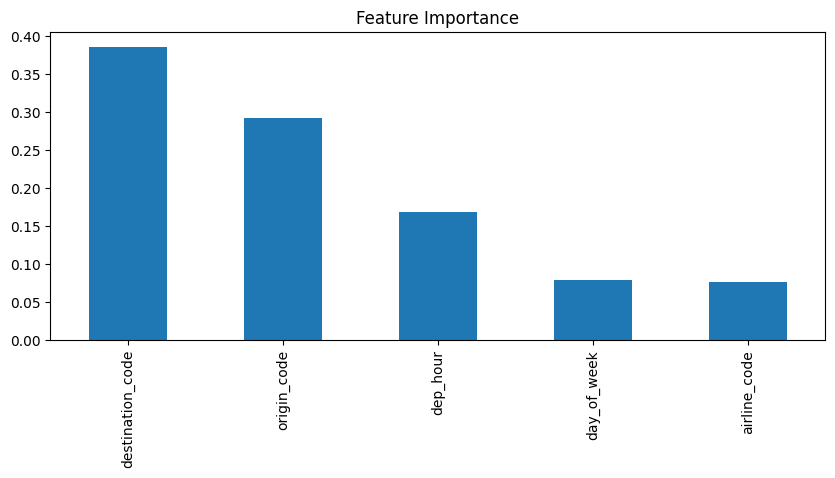

In [41]:
importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
importances.sort_values(ascending=False).plot(kind='bar', figsize=(10,4), title='Feature Importance')


This model did well on delayed flights, but it misses on a lot of actual delays (~16k false negatives). Improvements could be rebalancing the data or feature engineering

## RF with Class Balancing

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

Giving more weight to the minority class, delayed flights

In [43]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

In [44]:
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [45]:
y_pred = rf_model.predict(X_test)

In [46]:
accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Accuracy: {accuracy:.4f}")

✅ Accuracy: 0.6902


In [47]:
conf_matrix = confusion_matrix(y_test, y_pred)
print("📊 Confusion Matrix:")
print(conf_matrix)

📊 Confusion Matrix:
[[66663 19039]
 [13420  5643]]


<Axes: title={'center': 'Feature Importance'}>

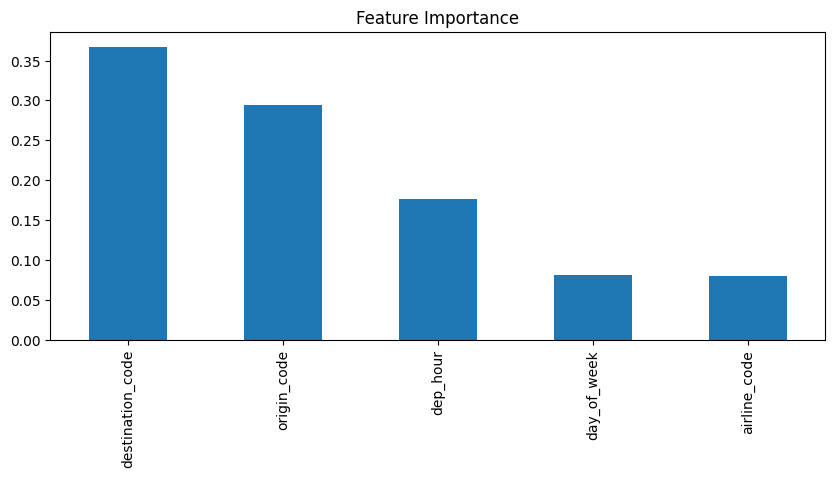

In [48]:
importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
importances.sort_values(ascending=False).plot(kind='bar', figsize=(10,4), title='Feature Importance')

In [49]:
print("\n Class Balance Classification Report:")
print(classification_report(y_test, y_pred, digits=4))


 Class Balance Classification Report:
              precision    recall  f1-score   support

       False     0.8324    0.7778    0.8042     85702
        True     0.2286    0.2960    0.2580     19063

    accuracy                         0.6902    104765
   macro avg     0.5305    0.5369    0.5311    104765
weighted avg     0.7226    0.6902    0.7048    104765



### Summary: Class Weighting vs No Class Weighting

I compared two Random Forest models:

- Without class weighting: higher overall accuracy (77%) but very low recall for delays (14.6%)
- With class weighting: lower accuracy (69%) but much better at catching delays (29.6% recall)

Conclusion: Using `class_weight='balanced'` helps the model detect more delays, which is more useful for real-world applications like airlines or airports.

# Improving Upon RF with Class Balancing + Weekend Feature

In [50]:
df['is_weekend'] = df['day_of_week'].isin([5, 6])

In [51]:
X = df_model.drop(['is_delayed', 'departure_delay_minutes'], axis=1)
X['is_weekend'] = df['is_weekend']

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [53]:
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced'
)

In [54]:
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [55]:
y_pred = rf_model.predict(X_test)

In [56]:
accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Accuracy: {accuracy:.4f}")

✅ Accuracy: 0.6901


In [57]:
conf_matrix = confusion_matrix(y_test, y_pred)
print("\n Confusion Matrix:")
print(conf_matrix)


 Confusion Matrix:
[[66705 18997]
 [13467  5596]]


In [58]:
print("\n Classification Report (w/ Weekend Feature):")
print(classification_report(y_test, y_pred, digits=4))


 Classification Report (w/ Weekend Feature):
              precision    recall  f1-score   support

       False     0.8320    0.7783    0.8043     85702
        True     0.2275    0.2936    0.2564     19063

    accuracy                         0.6901    104765
   macro avg     0.5298    0.5359    0.5303    104765
weighted avg     0.7220    0.6901    0.7046    104765



<Axes: title={'center': 'Feature Importance'}>

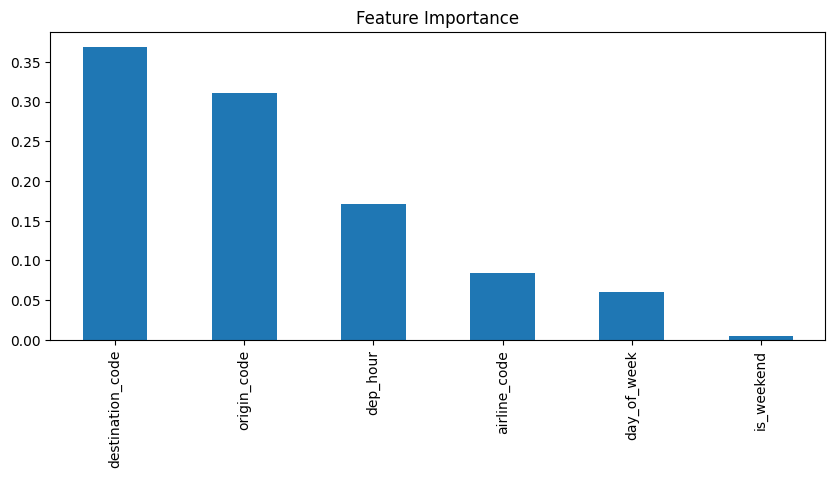

In [59]:
importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
importances.sort_values(ascending=False).plot(kind='bar', figsize=(10,4), title='Feature Importance')

### Summary: Random Forest (Class Balanced) + Weekend Feature

- Added a new feature: `is_weekend` (True if flight is on Saturday/Sunday)
- Retrained the Random Forest model with `class_weight='balanced'`
- Accuracy: **0.6901**
- Feature importance showed `is_weekend` had low but valid impact

Conclusion: Even small temporal signals (like weekends) help the model detect delays.  
Note: Further improvements could come from weather, holidays, or airport congestion.

# Adding Weather through Historical CSV

In [60]:
airport_url = "https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat"

In [61]:
airport_cols = ['AirportID', 'Name', 'City', 'Country', 'IATA', 'ICAO', 'Latitude', 'Longitude', 'Altitude',
                'Timezone', 'DST', 'TzDatabaseTimeZone', 'Type', 'Source']

In [62]:
df_airports = pd.read_csv(airport_url, header=None, names=airport_cols)

In [63]:
df_airports = df_airports[df_airports['IATA'].notnull() & df_airports['ICAO'].notnull()]

In [64]:
noaa_url = "https://www.ncei.noaa.gov/pub/data/noaa/isd-history.csv"

In [65]:
df_stations = pd.read_csv(noaa_url)

In [66]:
df_stations['STATION_ID'] = df_stations['USAF'].astype(str).str.zfill(6) + '-' + df_stations['WBAN'].astype(str).str.zfill(5)

In [67]:
df_stations = df_stations[
    (df_stations['LAT'].notnull()) &
    (df_stations['LON'].notnull()) &
    (df_stations['END'] >= 20250101) &
    (df_stations['ICAO'].notnull())
]

In [68]:
from scipy.spatial import cKDTree
import numpy as np

In [69]:
airport_coords = df_airports[['ICAO', 'Latitude', 'Longitude']].dropna()
station_coords = df_stations[['STATION_ID', 'LAT', 'LON']].dropna()

In [70]:
station_tree = cKDTree(station_coords[['LAT', 'LON']].values)

In [71]:
distances, indices = station_tree.query(airport_coords[['Latitude', 'Longitude']].values)

In [72]:
airport_coords['nearest_station_id'] = station_coords.iloc[indices].reset_index(drop=True)['STATION_ID']
airport_coords['station_distance_km'] = distances

In [73]:
unique_origins = df['origin'].unique()

In [74]:
df_origin_airports = df_airports[df_airports['IATA'].isin(unique_origins)]

In [75]:
airport_lookup = df_origin_airports.merge(
    airport_coords[['ICAO', 'nearest_station_id']],
    on='ICAO',
    how='left'
)

In [76]:
airport_lookup = airport_lookup[['IATA', 'ICAO', 'nearest_station_id']].drop_duplicates()

In [77]:
station_ids = airport_lookup['nearest_station_id'].dropna().unique()

In [78]:
noaa_base_url = "https://www.ncei.noaa.gov/pub/data/noaa/isd-lite/2025/"
weather_urls = [f"{noaa_base_url}{station_id}-2025.gz" for station_id in station_ids]

In [79]:
import gzip

In [82]:
import os
import requests
os.makedirs("weather_lite", exist_ok=True)

for url in weather_urls:
    filename = url.split("/")[-1]
    filepath = os.path.join("weather_lite", filename)

    if not os.path.exists(filepath):
        try:
            print(f" Downloading {filename}...")
            response = requests.get(url, timeout=15)
            with open(filepath, "wb") as f:
                f.write(response.content)
            print(f" Saved to {filepath}")
        except Exception as e:
            print(f" Failed to download {filename}: {e}")
    else:
        print(f" Already exists: {filename}")


 Saved to weather_lite/917650-61705-2025.gz
 Saved to weather_lite/912320-41418-2025.gz
 Saved to weather_lite/912120-41415-2025.gz
 Saved to weather_lite/785430-11640-2025.gz
 Saved to weather_lite/785510-11624-2025.gz
 Saved to weather_lite/785140-11603-2025.gz
 Saved to weather_lite/785203-00398-2025.gz
 Saved to weather_lite/785260-11641-2025.gz
 Saved to weather_lite/912850-21504-2025.gz
 Saved to weather_lite/723440-13964-2025.gz
 Saved to weather_lite/727570-14916-2025.gz
 Saved to weather_lite/723723-23184-2025.gz
 Saved to weather_lite/724095-14792-2025.gz
 Saved to weather_lite/725090-14739-2025.gz
 Saved to weather_lite/724930-23230-2025.gz
 Saved to weather_lite/725500-14942-2025.gz
 Saved to weather_lite/911900-22516-2025.gz
 Saved to weather_lite/724500-03928-2025.gz
 Saved to weather_lite/724460-03947-2025.gz
 Saved to weather_lite/726410-14837-2025.gz
 Saved to weather_lite/722780-23183-2025.gz
 Saved to weather_lite/726070-14606-2025.gz
 Saved to weather_lite/722470-03

In [83]:
import os
merged_flights = []
for _, row in airport_lookup.iterrows():
    airport = row['IATA']
    station = row['nearest_station_id']
    weather_file = f"weather_lite/{station}-2025.gz"

    if not os.path.exists(weather_file):
        print(f" Skipping {airport} — file {weather_file} not found.")
        continue

    print(f" Processing {airport} ({station})")

    try:
        with gzip.open(weather_file, 'rt') as f:
            df_weather = pd.read_fwf(f, header=None)

        df_weather.columns = [
            'year', 'month', 'day', 'hour', 'air_temp', 'dew_point',
            'sea_level_pressure', 'wind_dir', 'wind_speed',
            'sky_cover', '1hr_precip', '6hr_precip'
        ]

        for col in ['air_temp', 'dew_point', 'wind_speed', '1hr_precip']:
            df_weather[col] = pd.to_numeric(df_weather[col], errors='coerce').replace(-9999, pd.NA)
            df_weather[col] /= 10

        df_weather = df_weather[df_weather['month'] == 1]
        df_weather['datetime'] = pd.to_datetime(df_weather[['year', 'month', 'day', 'hour']])
        df_weather['datetime'] = df_weather['datetime'].dt.floor('h')

        df_weather = df_weather[['datetime', 'air_temp', 'wind_speed', '1hr_precip']]

    except Exception as e:
        print(f" Weather parse failed for {airport}: {e}")
        continue

    df_flights = df[df['origin'] == airport].copy()
    if df_flights.empty:
        print(f" No flights for {airport}")
        continue

    df_flights['datetime'] = pd.to_datetime(df_flights['flight_date']) + pd.to_timedelta(df_flights['dep_hour'], unit='h')
    df_flights['datetime'] = df_flights['datetime'].dt.floor('h')

    df_merged = df_flights.merge(df_weather, on='datetime', how='left')
    print(f"{airport}: merged {df_merged.shape[0]} rows")

    merged_flights.append(df_merged)

 Processing PPG (917650-61705)
PPG: merged 9 rows
 Processing SPN (912320-41418)
SPN: merged 31 rows
 Processing GUM (912120-41415)
GUM: merged 62 rows
 Processing STT (785430-11640)
STT: merged 501 rows
 Processing STX (785510-11624)
STX: merged 145 rows
 Processing BQN (785140-11603)
BQN: merged 202 rows
 Processing PSE (785203-00398)
PSE: merged 45 rows
 Processing SJU (785260-11641)
SJU: merged 3163 rows
 Processing ITO (912850-21504)
ITO: merged 558 rows
 Processing FSM (723440-13964)
FSM: merged 86 rows
 Processing GFK (727570-14916)
GFK: merged 53 rows
 Processing PRC (723723-23184)
PRC: merged 61 rows
 Processing TTN (724095-14792)
TTN: merged 77 rows
 Processing BOS (725090-14739)
BOS: merged 10376 rows
 Processing OAK (724930-23230)
OAK: merged 2845 rows
 Processing OMA (725500-14942)
OMA: merged 1852 rows
 Processing OGG (911900-22516)
OGG: merged 2193 rows
 Processing ICT (724500-03928)
ICT: merged 748 rows
 Processing MCI (724460-03947)
MCI: merged 3193 rows
 Processing MS

<ipython-input-83-56493f98de25>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weather['datetime'] = pd.to_datetime(df_weather[['year', 'month', 'day', 'hour']])
<ipython-input-83-56493f98de25>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weather['datetime'] = df_weather['datetime'].dt.floor('h')


GEG: merged 1234 rows
 Processing SFO (724940-23234)
SFO: merged 10761 rows
 Processing GNV (747560-12816)
GNV: merged 177 rows
 Processing MEM (723340-13893)
MEM: merged 1463 rows
 Processing LAX (722950-23174)
LAX: merged 15010 rows
 Processing CLE (725240-14820)
CLE: merged 2861 rows
 Processing CVG (724210-93814)
CVG: merged 2297 rows
 Processing JNU (703810-25309)
JNU: merged 327 rows
 Processing LFT (722405-13976)
LFT: merged 154 rows
 Processing EWR (725020-14734)
EWR: merged 9937 rows
 Processing BOI (726810-24131)
BOI: merged 1830 rows
 Processing GCK (724515-23064)
GCK: merged 58 rows
 Processing MOT (727676-24013)
MOT: merged 210 rows
 Processing DAL (722580-13960)
DAL: merged 5464 rows
 Processing HLN (727720-24144)
HLN: merged 144 rows
 Processing LCH (722400-03937)
LCH: merged 78 rows
 Processing KOA (911975-21510)
KOA: merged 1357 rows
 Processing MYR (747910-13717)


<ipython-input-83-56493f98de25>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weather['datetime'] = pd.to_datetime(df_weather[['year', 'month', 'day', 'hour']])
<ipython-input-83-56493f98de25>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weather['datetime'] = df_weather['datetime'].dt.floor('h')


MYR: merged 685 rows
 Processing DCA (724050-13743)
DCA: merged 10658 rows
 Processing ACY (724070-93730)
ACY: merged 201 rows
 Processing PQI (727130-14604)
PQI: merged 31 rows
 Processing ADQ (703500-25501)
ADQ: merged 58 rows
 Processing FLL (747830-12849)
FLL: merged 7720 rows
 Processing INL (727470-14918)
INL: merged 54 rows
 Processing SLC (725720-24127)
SLC: merged 9276 rows
 Processing MDT (723990-14711)
MDT: merged 298 rows
 Processing LNK (725510-14939)
LNK: merged 160 rows
 Processing LAN (725390-14836)
LAN: merged 101 rows
 Processing IAH (722430-12960)
IAH: merged 8739 rows
 Processing BFL (723840-23155)
BFL: merged 239 rows
 Processing ELP (722700-23044)
ELP: merged 1307 rows
 Processing HRL (722505-12904)
HRL: merged 362 rows
 Processing CAE (723100-13883)
CAE: merged 452 rows
 Processing PNS (722223-13899)
PNS: merged 799 rows
 Processing HOU (722440-12918)
HOU: merged 3863 rows
 Processing PIT (725200-94823)
PIT: merged 3006 rows
 Processing BRW (700260-27502)
BRW: me

<ipython-input-83-56493f98de25>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weather['datetime'] = pd.to_datetime(df_weather[['year', 'month', 'day', 'hour']])
<ipython-input-83-56493f98de25>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weather['datetime'] = df_weather['datetime'].dt.floor('h')
<ipython-input-83-56493f98de25>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

MAF: merged 746 rows
 Processing GRB (726450-14898)
GRB: merged 281 rows
 Processing AGS (722180-03820)
AGS: merged 150 rows
 Processing LIT (723403-13963)
LIT: merged 902 rows
 Processing SWF (725038-14714)
SWF: merged 47 rows
 Processing DFW (722590-03927)
DFW: merged 23580 rows
 Processing MLB (722040-12838)
MLB: merged 231 rows
 Processing AUS (722540-13904)
AUS: merged 6000 rows
 Processing LCK (724285-13812)
LCK: merged 63 rows
 Processing MQT (726284-94836)
MQT: merged 90 rows
 Processing TYS (723260-13891)
TYS: merged 921 rows
 Processing STL (724340-13994)
STL: merged 4396 rows
 Processing SPS (723510-13966)
SPS: merged 59 rows
 Processing ATL (722190-13874)
ATL: merged 22694 rows
 Processing GRR (726350-94860)
GRR: merged 1313 rows
 Processing FAT (723890-93193)
FAT: merged 915 rows
 Processing BNA (723270-13897)
BNA: merged 7089 rows
 Processing LRD (722520-12907)
LRD: merged 151 rows
 Processing OTZ (701330-26616)
OTZ: merged 25 rows
 Processing LGA (725030-14732)
LGA: merg

<ipython-input-83-56493f98de25>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weather['datetime'] = pd.to_datetime(df_weather[['year', 'month', 'day', 'hour']])


TYR: merged 88 rows
 Processing BWI (724060-93721)
BWI: merged 6783 rows
 Processing AEX (747540-93915)
AEX: merged 84 rows
 Processing TUL (723560-13968)
TUL: merged 1241 rows
 Processing SIT (703710-25333)
SIT: merged 91 rows
 Processing ISP (725050-04781)
ISP: merged 408 rows
 Processing MSP (726580-14922)
MSP: merged 8395 rows
 Processing MSY (722310-12916)
MSY: merged 3788 rows
 Processing PWM (726060-14764)
PWM: merged 538 rows
 Processing OKC (723530-13967)
OKC: merged 1667 rows
 Processing ALB (725180-14735)
ALB: merged 855 rows
 Processing SNA (722977-93184)
SNA: merged 3419 rows
 Processing CPR (725690-24089)
CPR: merged 183 rows
 Processing VPS (722210-13858)
VPS: merged 530 rows
 Processing EYW (722010-12836)
EYW: merged 740 rows
 Processing CLT (723140-13881)
CLT: merged 16125 rows
 Processing LAS (723860-23169)
LAS: merged 14846 rows
 Processing MCO (722050-12815)
MCO: merged 12851 rows
 Processing GTF (727750-24143)


<ipython-input-83-56493f98de25>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weather['datetime'] = pd.to_datetime(df_weather[['year', 'month', 'day', 'hour']])
<ipython-input-83-56493f98de25>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weather['datetime'] = df_weather['datetime'].dt.floor('h')


GTF: merged 221 rows
 Processing LWS (727830-24149)
LWS: merged 93 rows
 Processing ELM (725156-14748)
ELM: merged 87 rows
 Processing MRY (724915-23259)
MRY: merged 385 rows
 Processing SBA (723925-23190)
SBA: merged 555 rows
 Processing DAB (747870-12834)
DAB: merged 219 rows
 Processing AVL (723150-03812)
AVL: merged 593 rows
 Processing GSO (723170-13723)
GSO: merged 694 rows
 Processing FSD (726510-14944)
FSD: merged 543 rows
 Processing MHT (743945-14710)
MHT: merged 348 rows
 Processing SDF (724230-93821)
SDF: merged 1599 rows
 Processing CHO (724016-93736)
CHO: merged 84 rows
 Processing ROA (724110-13741)
ROA: merged 136 rows
 Processing LEX (724220-93820)
LEX: merged 582 rows
 Processing EVV (724320-93817)
EVV: merged 147 rows
 Processing ABQ (723650-23050)
ABQ: merged 1763 rows
 Processing BZN (726797-24132)
BZN: merged 771 rows
 Processing BIL (726770-24033)
BIL: merged 362 rows
 Processing BTM (727740-24135)
BTM: merged 56 rows
 Processing TVC (726387-14850)
TVC: merged 26

<ipython-input-83-56493f98de25>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weather['datetime'] = pd.to_datetime(df_weather[['year', 'month', 'day', 'hour']])
<ipython-input-83-56493f98de25>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weather['datetime'] = df_weather['datetime'].dt.floor('h')


RDD: merged 121 rows
 Processing EUG (726930-24221)
EUG: merged 559 rows
 Processing IDA (725785-24145)
IDA: merged 310 rows
 Processing MFR (725970-24225)
MFR: merged 337 rows
 Processing RDM (726920-24230)
RDM: merged 451 rows
 Processing CAK (725210-14895)
CAK: merged 290 rows
 Processing HSV (723230-03856)
HSV: merged 622 rows
 Processing MGM (722260-13895)
MGM: merged 172 rows
 Processing TRI (723350-13877)
TRI: merged 37 rows
 Processing FCA (727790-24146)
FCA: merged 252 rows
 Processing MBS (726379-14845)


<ipython-input-83-56493f98de25>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weather['datetime'] = pd.to_datetime(df_weather[['year', 'month', 'day', 'hour']])
<ipython-input-83-56493f98de25>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weather['datetime'] = df_weather['datetime'].dt.floor('h')


MBS: merged 173 rows
 Processing PSG (703860-25329)
PSG: merged 55 rows
 Processing SFB (722057-12854)
SFB: merged 787 rows
 Processing JST (725127-04726)
JST: merged 59 rows
 Processing MSO (727730-24153)
MSO: merged 285 rows
 Processing EGE (724675-23063)
EGE: merged 724 rows
 Processing LAW (723575-03950)
LAW: merged 87 rows
 Processing FLG (723750-03103)
FLG: merged 121 rows
 Processing TWF (725866-94178)
TWF: merged 61 rows
 Processing STC (726550-14926)
STC: merged 28 rows
 Processing MGW (724176-13736)
MGW: merged 46 rows
 Processing CRW (724140-13866)
CRW: merged 205 rows
 Processing AVP (725130-14777)
AVP: merged 112 rows
 Processing BJI (727550-14958)
BJI: merged 61 rows
 Processing FAR (727530-14914)
FAR: merged 603 rows
 Processing GCC (726650-94023)
GCC: merged 56 rows
 Processing SCE (725128-54739)
SCE: merged 16 rows
 Processing MEI (722340-13865)


<ipython-input-83-56493f98de25>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weather['datetime'] = pd.to_datetime(df_weather[['year', 'month', 'day', 'hour']])
<ipython-input-83-56493f98de25>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weather['datetime'] = df_weather['datetime'].dt.floor('h')


MEI: merged 50 rows
 Processing SPI (724390-93822)
SPI: merged 14 rows
 Processing HDN (725710-94025)
HDN: merged 331 rows
 Processing LBL (724516-23020)
LBL: merged 51 rows
 Processing COD (726700-24045)
COD: merged 61 rows
 Processing SGF (724400-13995)
SGF: merged 633 rows
 Processing JLN (723495-13987)
JLN: merged 58 rows
 Processing ABE (725170-14737)
ABE: merged 227 rows
 Processing XNA (723436-53922)
XNA: merged 898 rows
 Processing SBN (725350-14848)
SBN: merged 605 rows
 Processing ACV (725945-24283)
ACV: merged 143 rows
 Processing OAJ (723069-93753)
OAJ: merged 59 rows
 Processing ABR (726590-14929)
ABR: merged 61 rows
 Processing ABY (722160-13869)
ABY: merged 63 rows
 Processing APN (726390-94849)
APN: merged 54 rows
 Processing BFF (725660-24028)
BFF: merged 52 rows
 Processing CIU (727344-04869)
CIU: merged 61 rows
 Processing CKB (724175-03802)
CKB: merged 9 rows
 Processing CMX (727440-14858)
CMX: merged 55 rows
 Processing DDC (724510-13985)
DDC: merged 49 rows
 Proce

In [84]:
df_all = pd.concat(merged_flights).reset_index(drop=True)

In [86]:
df_all.to_csv("flights_with_weather.csv", index=False)

In [87]:
df_all.shape

(523595, 16)

In [88]:
df_all['1hr_precip'].isna().mean() * 100

np.float64(6.319197089353413)

In [89]:
df_all['1hr_precip'] = df_all['1hr_precip'].fillna(0)

<ipython-input-89-22109c6ff98b>:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_all['1hr_precip'] = df_all['1hr_precip'].fillna(0)


In [90]:
df_all['air_temp'] = df_all['air_temp'].fillna(0)

<ipython-input-90-b9eab3e42cdc>:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_all['air_temp'] = df_all['air_temp'].fillna(0)


In [91]:
df_all['wind_speed'] = df_all['wind_speed'].fillna(0)

<ipython-input-91-56b3c6675291>:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_all['wind_speed'] = df_all['wind_speed'].fillna(0)


In [92]:
df_all.head()

,flight_date,airline,origin,destination,dep_hour,day_of_week,departure_delay_minutes,is_delayed,airline_code,origin_code,destination_code,is_weekend,datetime,air_temp,wind_speed,1hr_precip
0,2025-01-02,HA,PPG,HNL,23,3,0.0,False,6,242,136,False,2025-01-02 23:00:00,28.4,2.1,0.0
1,2025-01-06,HA,PPG,HNL,23,0,0.0,False,6,242,136,False,2025-01-06 23:00:00,28.0,5.1,0.0
2,2025-01-07,HA,PPG,HNL,23,1,97.0,True,6,242,136,False,2025-01-07 23:00:00,26.1,6.7,0.0
3,2025-01-09,HA,PPG,HNL,23,3,0.0,False,6,242,136,False,2025-01-09 23:00:00,25.5,0.3,0.0
4,2025-01-13,HA,PPG,HNL,23,0,9.0,False,6,242,136,False,2025-01-13 23:00:00,29.2,2.6,0.0


# RF with Weather Data

In [93]:
import pandas as pd

In [94]:
df_all['is_weekend'] = df_all['day_of_week'].isin([6, 7]).astype(int)

In [95]:
df_all.columns

Index(['flight_date', 'airline', 'origin', 'destination', 'dep_hour',
       'day_of_week', 'departure_delay_minutes', 'is_delayed', 'airline_code',
       'origin_code', 'destination_code', 'is_weekend', 'datetime', 'air_temp',
       'wind_speed', '1hr_precip'],
      dtype='object')

In [96]:
features = ['dep_hour', 'day_of_week', 'is_weekend',
    'airline_code', 'origin_code', 'destination_code',
    'air_temp', 'wind_speed', '1hr_precip'
]

In [97]:
X = df_all[features]
y = df_all['is_delayed']

In [98]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [100]:
model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)

In [101]:
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [102]:
y_pred = model.predict(X_test)

In [103]:
print("Accuracy:", accuracy_score(y_test, y_pred))

✅ Accuracy: 0.8052215930251435


In [104]:
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Confusion Matrix:
[[80725  5007]
 [15390  3597]]


In [105]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

       False       0.84      0.94      0.89     85732
        True       0.42      0.19      0.26     18987

    accuracy                           0.81    104719
   macro avg       0.63      0.57      0.57    104719
weighted avg       0.76      0.81      0.77    104719



<Axes: title={'center': 'Feature Importance'}>

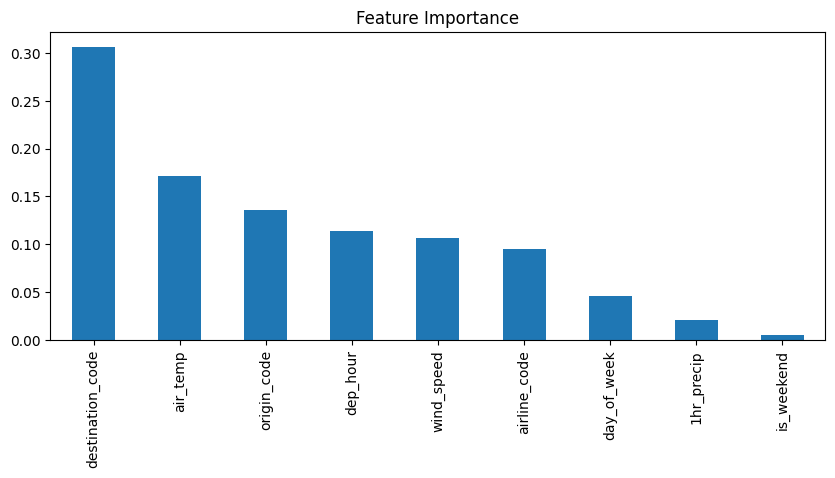

In [106]:
importances = pd.Series(model.feature_importances_, index=X_train.columns)
importances.sort_values(ascending=False).plot(kind='bar', figsize=(10, 4), title='Feature Importance')

I trained a Random Forest to predict flight delays using operational and weather features. The model reached 80.5% accuracy, with strong performance on non-delays but low recall for actual delays.

Key features included destination, air temperature, and origin. Weather added value, especially temperature and wind speed, while 1hr_precip and is_weekend had minimal impact.

Next, I’ll try XGBoost to improve recall and overall balance.

# XGBoost

In [107]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [108]:
features = [
    'dep_hour', 'day_of_week', 'is_weekend',
    'airline_code', 'origin_code', 'destination_code',
    'air_temp', 'wind_speed', '1hr_precip'
]

In [109]:
X = df_all[features]
y = df_all['is_delayed']

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [111]:
model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    scale_pos_weight=(len(y_train) / y_train.sum())
)

In [112]:
model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:33:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [113]:
y_pred = model.predict(X_test)

In [114]:
print("✅ Accuracy:", accuracy_score(y_test, y_pred))

✅ Accuracy: 0.5457557845281181


In [115]:
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Confusion Matrix:
[[42815 42917]
 [ 4651 14336]]


In [116]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

       False       0.90      0.50      0.64     85732
        True       0.25      0.76      0.38     18987

    accuracy                           0.55    104719
   macro avg       0.58      0.63      0.51    104719
weighted avg       0.78      0.55      0.59    104719



<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

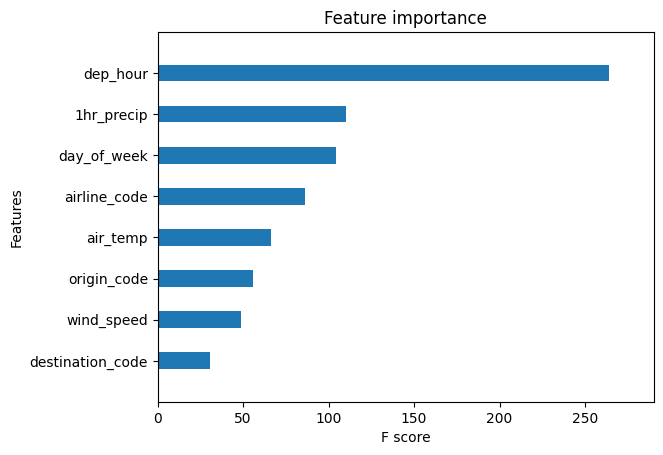

In [117]:
xgb.plot_importance(model, importance_type='gain', height=0.4, grid=False, show_values=False)

XGBoost significantly improved delay recall (76%) compared to Random Forest (19%), catching more real delays at the cost of overall accuracy. Weather features like 1hr_precip gained importance, and departure hour became the most influential feature. This model favors real-world use cases where predicting delays is critical.

# Creating New Inputs to Predict

In [124]:
def predict_delay(airline, origin, destination, dep_hour, day_of_week, is_weekend,
                  air_temp, wind_speed, precip, model=model):
    try:
        airline_code = df_all['airline'].astype('category').cat.categories.get_loc(airline)
        origin_code = df_all['origin'].astype('category').cat.categories.get_loc(origin)
        destination_code = df_all['destination'].astype('category').cat.categories.get_loc(destination)
    except KeyError as e:
        raise ValueError(f"Unknown value: {e}")

    input_data = pd.DataFrame([{
        'dep_hour': dep_hour,
        'day_of_week': day_of_week,
        'is_weekend': is_weekend,
        'airline_code': airline_code,
        'origin_code': origin_code,
        'destination_code': destination_code,
        'air_temp': air_temp,
        'wind_speed': wind_speed,
        '1hr_precip': precip
    }])

    prediction = model.predict(input_data)[0]
    proba = model.predict_proba(input_data)[0][1]

    label = "DELAYED" if prediction == 1 else "ON TIME"
    print(f"✈️ Prediction: {label} (class={prediction}) - Probability of delay: {proba:.2f}")

    return prediction, proba


In [125]:
predict_delay(
    airline='AA',
    origin='JFK',
    destination='LAX',
    dep_hour=15,
    day_of_week=5,
    is_weekend=0,
    air_temp=30.0,
    wind_speed=5.2,
    precip=0.0
)

✈️ Prediction: DELAYED (class=1) - Probability of delay: 0.53


(np.int64(1), np.float32(0.5275923))

# Visualizations

In [126]:
import seaborn as sns
import matplotlib.pyplot as plt

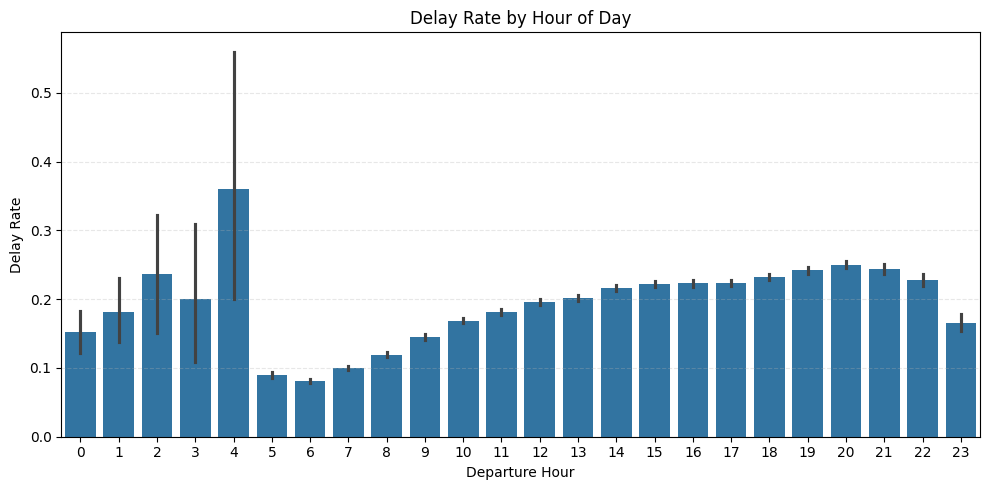

In [128]:
plt.figure(figsize=(10, 5))
sns.barplot(data=df_all, x='dep_hour', y='is_delayed', estimator='mean')
plt.title("Delay Rate by Hour of Day")
plt.ylabel("Delay Rate")
plt.xlabel("Departure Hour")
plt.xticks(range(0, 24))
plt.grid(True, axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

Flights departing in the early morning (around 4–6 AM) and late evening (after 6 PM) tend to experience higher delay rates. In contrast, mid-morning and early afternoon flights (especially between 8 AM and 1 PM) show the lowest delay probability. This suggests that operational bottlenecks and accumulated delays later in the day may play a key role in increasing delays.



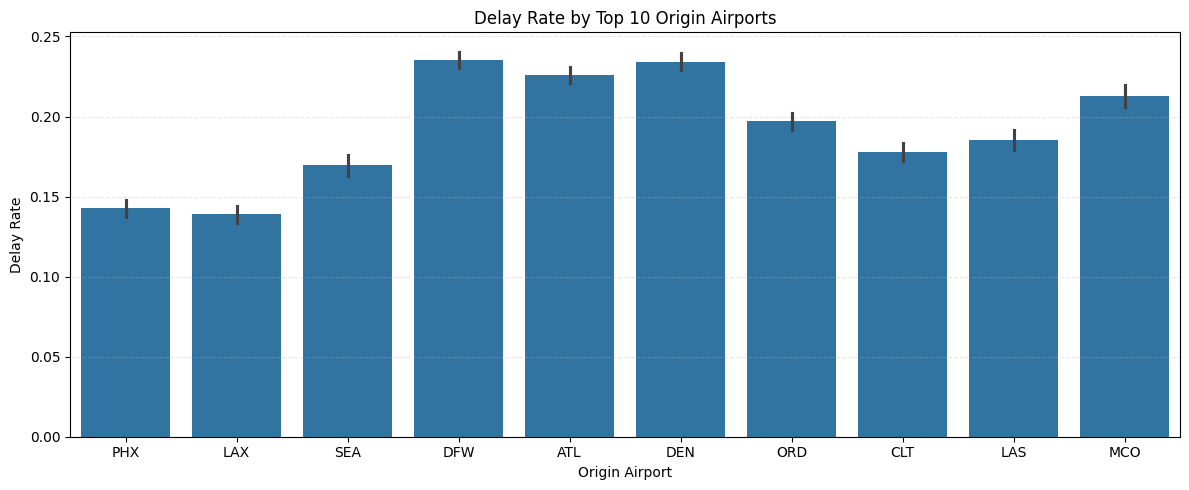

In [130]:
top_airports = df_all['origin'].value_counts().head(10).index

plt.figure(figsize=(12, 5))
sns.barplot(data=df_all[df_all['origin'].isin(top_airports)],
            x='origin', y='is_delayed', estimator='mean')
plt.title("Delay Rate by Top 10 Origin Airports")
plt.ylabel("Delay Rate")
plt.xlabel("Origin Airport")
plt.grid(True, axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

Among the busiest origin airports, DFW (Dallas-Fort Worth) and DEN (Denver) show the highest average delay rates, each exceeding 23%. In contrast, PHX (Phoenix) and LAX (Los Angeles) exhibit lower delay rates, closer to 14%. This suggests that certain hubs may experience more operational congestion or weather-related disruptions, even if they handle similar volumes of flights.

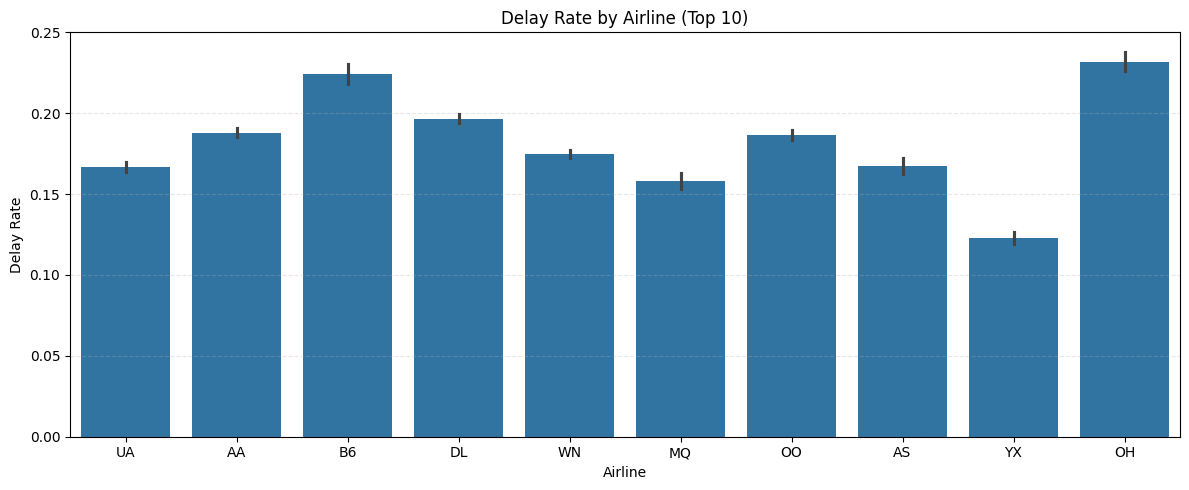

In [134]:
top_airlines = df_all['airline'].value_counts().head(10).index

plt.figure(figsize=(12, 5))
sns.barplot(data=df_all[df_all['airline'].isin(top_airlines)],
            x='airline', y='is_delayed', estimator='mean')
plt.title("Delay Rate by Airline (Top 10)")
plt.ylabel("Delay Rate")
plt.xlabel("Airline")
plt.grid(True, axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

Among the top 10 most active airlines, OH and B6 stand out with the highest average delay rates, each exceeding 22%. On the other end, YX and MQ show the lowest delay rates. This suggests that performance can vary significantly between carriers, likely due to differences in scheduling buffers, hub congestion, and resource allocation.

## **Visual Summary**

I created three key visualizations to explore what factors contribute most to flight delays:

**Delay Rate by Hour of Day**

Revealed that delays are more common during early mornings and evenings, likely due to operational bottlenecks and accumulated delays.

**Delay Rate by Origin Airport**

Showed that some airports (like DFW and DEN) consistently report higher delay rates than others, reflecting airport-specific congestion or weather patterns.

**Delay Rate by Airline**

Highlighted that delay likelihood varies by carrier, with OH and B6 experiencing higher delay rates compared to others like YX or MQ.

These insights align closely with the model’s learned feature importance and help validate which inputs actually impact delays.

# Exporting to PowerBI

In [150]:
df_all_export = df_all[[
    'flight_date', 'airline', 'origin', 'destination',
    'dep_hour', 'day_of_week', 'is_weekend',
    'air_temp', 'wind_speed', '1hr_precip',
    'departure_delay_minutes', 'is_delayed'
]]

In [151]:
df_all_export['prediction'] = model.predict(df_all[features])

<ipython-input-151-401deb22a7d4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_export['prediction'] = model.predict(df_all[features])


In [152]:
df_all_export['prob_delayed'] = model.predict_proba(df_all[features])[:, 1].round(3)

<ipython-input-152-1194b7c16573>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_export['prob_delayed'] = model.predict_proba(df_all[features])[:, 1].round(3)


In [153]:
df_all_export.to_csv("/content/drive/MyDrive/Colab Notebooks/Airport Project/flights_with_pred.csv", index= False)